In [107]:
import sys
import os
import time
sys.path.append(os.path.abspath('../..'))

import gpflow
import tensorflow as tf
from gpflow.optimizers import Scipy

from rcgp.morcgp import MOGPRegressor, MORCGP
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.covariance import MinCovDet
import pandas as pd

plt.rcParams.update({
    "text.usetex": True,         
    "font.family": "serif",       
    "text.latex.preamble": r"\usepackage{amsmath}",
    'font.size': 24,         
    'axes.labelsize': 18,    
    'xtick.labelsize': 22,   
    'ytick.labelsize': 22,  
    'legend.fontsize': 20,
    'lines.linewidth': 5,    
    'lines.markersize': 8   
})

In [108]:
df = pd.read_csv('navitoclax.csv')
df

,Unnamed: 0,cell_line,COSMIC_ID,drug,log10_dose,viability
0,1,22RV1,924100,Navitoclax,-2.6987,0.996820
1,2,22RV1,924100,Navitoclax,-2.3008,0.927539
2,3,22RV1,924100,Navitoclax,-2.1988,1.022289
3,4,22RV1,924100,Navitoclax,-1.9998,1.038805
4,5,22RV1,924100,Navitoclax,-1.8008,0.923463
...,...,...,...,...,...,...
17666,17667,no-11,908450,Navitoclax,-1.6988,0.906616
17667,17668,no-11,908450,Navitoclax,-1.1989,0.961543
17668,17669,no-11,908450,Navitoclax,-0.6989,0.896100
17669,17670,no-11,908450,Navitoclax,-0.1989,0.848893


In [131]:
def preprocess_data(df, cell_lines):
    df_copy = df[['cell_line', 'log10_dose', 'viability']]
    df_subset = df_copy[df_copy['cell_line'].isin(cell_lines)]

    # Pivot
    pivoted = df_subset.pivot(index='cell_line', columns='log10_dose', values='viability')
    pivoted = pivoted.loc[cell_lines]

    Y = pivoted.to_numpy()
    x = pivoted.columns.to_numpy().reshape(-1, 1)

    return x, Y.T

list_cell_lines = ['P12-ICHIKAWA', 'ARH-77']
x, Y = preprocess_data(df, list_cell_lines)

In [132]:
# Initialization
n_outputs = len(list_cell_lines)
prior_mean = 0.5
init_length_scale = 1.0
init_noise_var = np.array([0.005]*n_outputs)
N, D = Y.shape

Y_clean = Y[~np.isnan(Y).any(axis=1)]
mcd = MinCovDet(support_fraction=0.9).fit(Y_clean)
robust_covariance = mcd.covariance_
robust_init_A = np.linalg.cholesky(robust_covariance)
empty_noise = np.array([1e-6]*n_outputs)

# Instantiate and train
mogp = MOGPRegressor(mean = prior_mean, length_scale=init_length_scale, noise = init_noise_var, A=robust_init_A)
mogp.fit(x, Y)
mogp.optimize_hyperparameters()

# Predict on test points
x_test = np.linspace(-2.7, 1.5, 200).reshape(-1, 1)
mu_mogp, var_mogp = mogp.predict(x_test)
# std_mogp = np.sqrt(var_mogp + mogp.noise)
std_mogp = np.sqrt(var_mogp)

In [133]:
# Initialization
n_outputs = len(list_cell_lines)
prior_mean = 0.5
init_length_scale = 2
# init_noise_var = np.array([0.005]*n_outputs)
epsilon = 0.2

Y_clean = Y[~np.isnan(Y).any(axis=1)]
mcd = MinCovDet(support_fraction=0.9).fit(Y_clean)
robust_covariance = mcd.covariance_
robust_init_A = np.linalg.cholesky(robust_covariance)
empty_noise = np.array([1e-6]*n_outputs)

# Instantiate and train
morcgp = MORCGP(mean=prior_mean, length_scale=init_length_scale, noise_var=mogp.noise, A=robust_init_A)
morcgp.fit(x, Y, epsilons=np.array([epsilon]*2))
init_gamma, init_c, gamma, c = morcgp.optimize_loo_cv(print_opt_param = True, print_iter_objective=False, k=2, init_cov=robust_covariance, fix_weights=True)

# Predict on test points
# x_test = np.linspace(-2.7, 1.5, 100).reshape(-1, 1)
mu_morcgp, var_morcgp = morcgp.predict(x_test)
# std_morcgp = np.sqrt(var_morcgp + morcgp.noise_var)
std_morcgp = np.sqrt(var_morcgp)

Optimized length_scale: 1.9741
Optimized noise_var: [0.01240674 0.00655854]
Optimized A: [[21.36416447  4.71665783]
 [18.52647535  4.13792019]]
Optimized B: 
[[478.67438442 415.31982001]
 [415.31982001 360.35267238]]


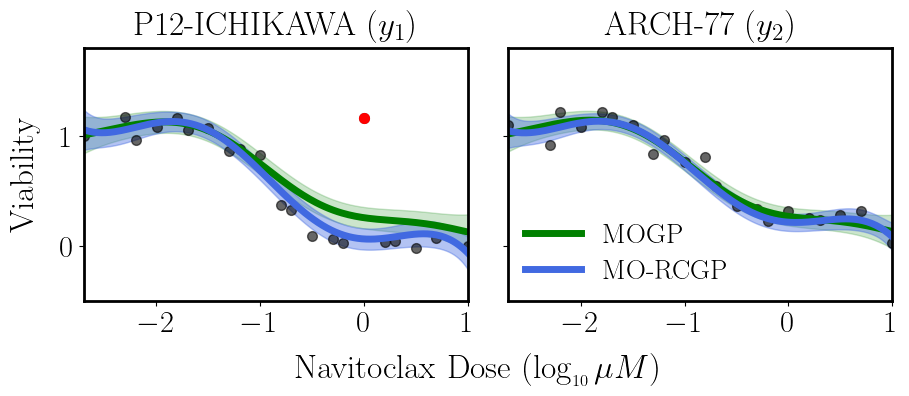

In [134]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

for i in range(n_outputs):
    # Plotting data and predictions
    axs[i].plot(x.flatten(), Y[:, i], 'o', color='black', alpha=0.6, markersize=7)
    axs[i].plot(x_test.flatten(), mu_mogp[:, i], '-', color='green', label='MOGP', linewidth=5)
    axs[i].fill_between(x_test.flatten(),
                        mu_mogp[:, i] - 2*std_mogp[:, i],
                        mu_mogp[:, i] + 2*std_mogp[:, i],
                        color='green', alpha=0.2)
    
    axs[i].plot(x_test.flatten(), mu_morcgp[:, i], '-', color='royalblue', label='MO-RCGP', linewidth=5)
    axs[i].fill_between(x_test.flatten(),
                        mu_morcgp[:, i] - 2*std_morcgp[:, i],
                        mu_morcgp[:, i] + 2*std_morcgp[:, i],
                        color='royalblue', alpha=0.4)

    # Axes limits
    axs[i].set_ylim([-0.5, 1.8])
    axs[i].set_xlim([x[0], x[-1]])

    # Titles and labels
    if i == 0:
        axs[i].set_title(r"P12-ICHIKAWA ($y_1$)", fontsize=24, pad=10)
        axs[i].set_ylabel("Viability", fontsize=24, labelpad=15)
    elif i == 1:
        axs[i].set_title(r"ARCH-77 ($y_2$)", fontsize=24, pad=10)
        axs[i].set_yticklabels([])
        axs[i].legend(loc='lower left', fontsize=20, frameon=False, borderpad=0.1, labelspacing=0.4)

    # **Thick borders (spines)**
    for spine in axs[i].spines.values():
        spine.set_linewidth(2)  # change '3' to any thickness you want

# X-axis label
fig.text(0.55, -0.01, r'Navitoclax Dose $(\log_{\scriptscriptstyle 10}{\mu M})$', ha='center', fontsize=24)
axs[0].plot(x[15, 0], Y[15, 0], 'o', color='red', alpha=1, markersize=7)
plt.tight_layout()
plt.show()
# fig.savefig("./navitoclax.pdf", format='pdf', bbox_inches='tight')

## t-MOGP

In [135]:
def make_X_multi(X, D=2):
    """
    X: shape (N, input_dim) - multi-dimensional input
    D: number of tasks
    """
    N, input_dim = X.shape
    X_multi = []
    
    for task in range(D):
        # Add task index as last column
        X_task = np.hstack([X, np.full((N, 1), task)])
        X_multi.append(X_task)
    
    return np.vstack(X_multi)  # Shape: (N*D, input_dim + 1)

In [136]:
prior_mean = 0.5
mean_fn = gpflow.mean_functions.Constant(prior_mean)

X_multi_train = make_X_multi(x, D=2)
X_multi_test = make_X_multi(x_test, D=2)
Y_multi_train = Y.reshape(-1, 1, order='F')

mask = ~np.isnan(Y_multi_train[:, 0])
X_multi_train_masked = X_multi_train[mask]
Y_multi_train_masked = Y_multi_train[mask]

input_dim = x.shape[1]  
N = x.shape[0]
D = 2

base_kernel = gpflow.kernels.RBF(
    lengthscales=1.0, 
    variance=0.1, 
    active_dims=list(range(input_dim)) ,
)

coregion_kernel = gpflow.kernels.Coregion(
    output_dim=D, 
    rank=D, 
    active_dims=[input_dim]  
)

gpflow.utilities.set_trainable(base_kernel.variance, False)

gpflow.utilities.set_trainable(coregion_kernel.kappa, False)
coregion_kernel.kappa.assign(tf.ones_like(coregion_kernel.kappa) * 1e-6)

kernel = base_kernel * coregion_kernel

likelihood_vgp = gpflow.likelihoods.StudentT(df=8)
model_vgp = gpflow.models.VGP(
    data=(X_multi_train_masked, Y_multi_train_masked),
    kernel=kernel,
    likelihood=likelihood_vgp,
    mean_function=mean_fn
)

opt = Scipy()
def objective_closure_vgp():
    return -model_vgp.maximum_log_likelihood_objective()

try:
    opt.minimize(objective_closure_vgp, model_vgp.trainable_variables, options=dict(maxiter=1000))
except Exception as e:
    print(f"Optimization failed: {e}")
    print("Try reducing maxiter or checking data shapes")

mean_pred_tmogp, var_pred_tmogp = model_vgp.predict_y(X_multi_test)
mu_tmogp, std_tmogp = mean_pred_tmogp.numpy().reshape(-1, D, order='F'), np.sqrt(var_pred_tmogp.numpy()).reshape(-1, D, order='F')

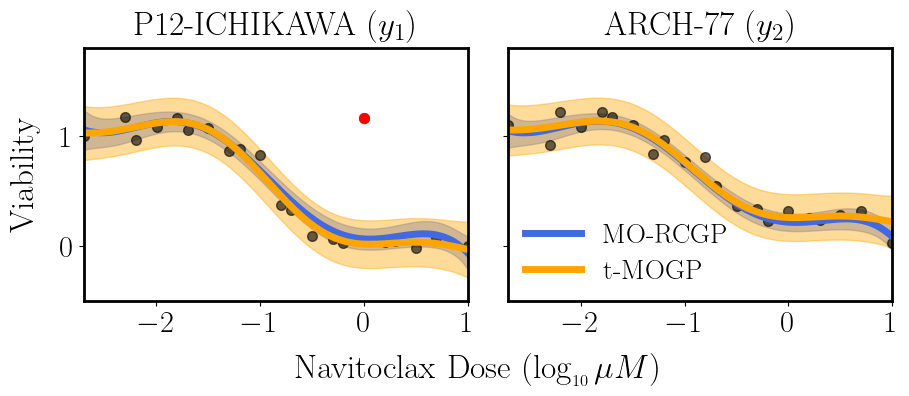

In [137]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

for i in range(n_outputs):
    # Plotting data and predictions
    axs[i].plot(x.flatten(), Y[:, i], 'o', color='black', alpha=0.6, markersize=7)
    # axs[i].plot(x_test.flatten(), mu_mogp[:, i], '-', color='green', label='MOGP', linewidth=5)
    # axs[i].fill_between(x_test.flatten(),
    #                     mu_mogp[:, i] - 2*std_mogp[:, i],
    #                     mu_mogp[:, i] + 2*std_mogp[:, i],
    #                     color='green', alpha=0.2)
    
    axs[i].plot(x_test.flatten(), mu_morcgp[:, i], '-', color='royalblue', label='MO-RCGP', linewidth=5)
    axs[i].fill_between(x_test.flatten(),
                        mu_morcgp[:, i] - 2*std_morcgp[:, i],
                        mu_morcgp[:, i] + 2*std_morcgp[:, i],
                        color='royalblue', alpha=0.4)
    axs[i].plot(x_test.flatten(), mu_tmogp[:, i], '-', color='orange', label='t-MOGP', linewidth=5)
    axs[i].fill_between(x_test.flatten(),
                        mu_tmogp[:, i] - 2*std_tmogp[:, i],
                        mu_tmogp[:, i] + 2*std_tmogp[:, i],
                        color='orange', alpha=0.4)

    # Axes limits
    axs[i].set_ylim([-0.5, 1.8])
    axs[i].set_xlim([x[0], x[-1]])

    # Titles and labels
    if i == 0:
        axs[i].set_title(r"P12-ICHIKAWA ($y_1$)", fontsize=24, pad=10)
        axs[i].set_ylabel("Viability", fontsize=24, labelpad=15)
    elif i == 1:
        axs[i].set_title(r"ARCH-77 ($y_2$)", fontsize=24, pad=10)
        axs[i].set_yticklabels([])
        axs[i].legend(loc='lower left', fontsize=20, frameon=False, borderpad=0.1, labelspacing=0.4)

    # **Thick borders (spines)**
    for spine in axs[i].spines.values():
        spine.set_linewidth(2)  # change '3' to any thickness you want

# X-axis label
fig.text(0.55, -0.01, r'Navitoclax Dose $(\log_{\scriptscriptstyle 10}{\mu M})$', ha='center', fontsize=24)
axs[0].plot(x[15, 0], Y[15, 0], 'o', color='red', alpha=1, markersize=7)
plt.tight_layout()
plt.show()

Intervals for IC_50

In [139]:
def get_interval_IC50(mu, std):
    # Compute the lower and upper bounds of the 95% CI
    lower = mu[:, 0] - 1.96 * std[:, 0]
    upper = mu[:, 0] + 1.96 * std[:, 0]

    # Find indices where 0.5 is inside the CI
    indices = np.where((0.5 >= lower) & (0.5 <= upper))[0]

    # Optional: get the corresponding x_test values
    x_values = x_test[indices, 0]

    print("Values:", mu[indices, 0])
    print("x_test values:", x_values)

get_interval_IC50(mu_morcgp, std_morcgp)

Values: [0.57795573 0.55821913 0.53854951 0.51897617 0.4995282  0.48023438
 0.46112309 0.4422223  0.42355946]
x_test values: [-0.88492462 -0.8638191  -0.84271357 -0.82160804 -0.80050251 -0.77939698
 -0.75829146 -0.73718593 -0.7160804 ]


## LOO evaluation

In [103]:
rmse_mogp_list = []
nlpd_mogp_list = []
time_mogp_list = []

rmse_morcgp_list = []
nlpd_morcgp_list = []
time_morcgp_list = []

rmse_tmogp_list = []
nlpd_tmogp_list = []
time_tmogp_list = []

for d in range(D):
    for i in range(N):
        if i == 15 and d == 0:
            continue
        loo_Y = Y.copy()
        loo_x = x.copy()

        loo_y_value = loo_Y[i, d]
        loo_x_value = loo_x[i, 0]
        loo_Y[i, d] = np.nan

        mcd = MinCovDet(support_fraction=0.9).fit(Y[~np.isnan(Y).any(axis=1)])
        robust_covariance = mcd.covariance_
        robust_init_A = np.linalg.cholesky(robust_covariance)

        # Instantiate and train
        start_time_mogp = time.time()
        mogp = MOGPRegressor(mean = prior_mean, length_scale=init_length_scale, noise = init_noise_var, A=robust_init_A)
        mogp.fit(x, Y)
        mogp.optimize_hyperparameters()
        x_test = np.array([[loo_x_value]])
        mu_mogp, var_mogp = mogp.predict(x_test)
        std_mogp = np.sqrt(var_mogp + mogp.noise)
        end_time_mogp = time.time()
        
        start_time_morcgp = time.time()
        epsilon = 0.2
        morcgp = MORCGP(mean=prior_mean, length_scale=init_length_scale, noise_var=mogp.noise, A=robust_init_A)
        morcgp.fit(x, Y, epsilons=np.array([epsilon]*2))
        morcgp.optimize_loo_cv(print_opt_param = False, print_iter_objective=False, k=2, init_cov=robust_covariance, fix_weights=True)
        mu_morcgp, var_morcgp = morcgp.predict(x_test)
        std_morcgp = np.sqrt(var_morcgp + morcgp.noise_var)
        end_time_morcgp = time.time()

        # t-MOGP
        start_time_tmogp = time.time()
        X_multi_train = make_X_multi(loo_x, D=2)
        X_multi_test = make_X_multi(x_test, D=2)
        Y_multi_train = loo_Y.reshape(-1, 1, order='F')
        mask = ~np.isnan(Y_multi_train[:, 0])
        X_multi_train_masked = X_multi_train[mask]
        Y_multi_train_masked = Y_multi_train[mask]
        base_kernel = gpflow.kernels.RBF(
            lengthscales=init_length_scale, 
            variance=0.005, 
            active_dims=list(range(input_dim)) ,
        )
        coregion_kernel = gpflow.kernels.Coregion(
            output_dim=D, 
            rank=D, 
            active_dims=[input_dim]  
        )
        gpflow.utilities.set_trainable(base_kernel.variance, False)
        gpflow.utilities.set_trainable(coregion_kernel.kappa, False)
        coregion_kernel.kappa.assign(tf.ones_like(coregion_kernel.kappa) * 1e-6)
        kernel = base_kernel * coregion_kernel
        likelihood_vgp = gpflow.likelihoods.StudentT(df=8)
        model_vgp = gpflow.models.VGP(
            data=(X_multi_train_masked, Y_multi_train_masked),
            kernel=kernel,
            likelihood=likelihood_vgp,
            mean_function=mean_fn
        )
        opt = Scipy()
        def objective_closure_vgp():
            return -model_vgp.maximum_log_likelihood_objective()
        try:
            opt.minimize(objective_closure_vgp, model_vgp.trainable_variables, options=dict(maxiter=1000))
        except Exception as e:
            print(f"Optimization failed: {e}")
            print("Try reducing maxiter or checking data shapes")

        mean_pred_tmogp, var_pred_tmogp = model_vgp.predict_y(X_multi_test)
        mu_tmogp, std_tmogp = mean_pred_tmogp.numpy().reshape(-1, D, order='F'), np.sqrt(var_pred_tmogp.numpy()).reshape(-1, D, order='F')
        end_time_tmogp = time.time()
        # print(mu_tmogp)

        # -----------------------------------------------------
        plot_figures = False
        if plot_figures:

            fig, axs = plt.subplots(1, 2, figsize=(10, 4))

            for k in range(n_outputs):
                # Plotting data and predictions
                axs[k].plot(x.flatten(), Y[:, k], 'o', color='black', alpha=0.6, markersize=7)
                # axs[k].plot(x_test.flatten(), mu_mogp[:, k], '-', color='green', label='MOGP', linewidth=5)
                # axs[k].fill_between(x_test.flatten(),
                #                     mu_mogp[:, k] - 2*std_mogp[:, k],
                #                     mu_mogp[:, k] + 2*std_mogp[:, k],
                #                     color='green', alpha=0.2)
                
                axs[k].plot(x_test.flatten(), mu_morcgp[:, k], '*', color='royalblue', label='MO-RCGP', linewidth=5)
                # axs[k].fill_between(x_test.flatten(),
                #                     mu_morcgp[:, k] - 2*std_morcgp[:, k],
                #                     mu_morcgp[:, k] + 2*std_morcgp[:, k],
                #                     color='royalblue', alpha=0.4)
                axs[k].plot(x_test.flatten(), mu_tmogp[:, k], '*', color='orange', label='t-MOGP', linewidth=5)
                # axs[k].fill_between(x_test.flatten(),
                #                     mu_tmogp[:, k] - 2*std_tmogp[:, k],
                #                     mu_tmogp[:, k] + 2*std_tmogp[:, k],
                #                     color='orange', alpha=0.4)

                # Axes limits
                axs[k].set_ylim([-0.5, 1.8])
                axs[k].set_xlim([x[0], x[-1]])

                # Titles and labels
                if k == 0:
                    axs[k].set_title(r"P12-ICHIKAWA ($y_1$)", fontsize=24, pad=10)
                    axs[k].set_ylabel("Viability", fontsize=24, labelpad=15)
                elif k == 1:
                    axs[k].set_title(r"ARCH-77 ($y_2$)", fontsize=24, pad=10)
                    axs[k].set_yticklabels([])
                    # axs[k].legend(loc='lower left', fontsize=20, frameon=False, borderpad=0.1, labelspacing=0.4)

                # **Thick borders (spines)**
                for spine in axs[k].spines.values():
                    spine.set_linewidth(2)  # change '3' to any thickness you want

            # X-axis label
            fig.text(0.55, -0.01, r'Navitoclax Dose $(\log_{\scriptscriptstyle 10}{\mu M})$', ha='center', fontsize=24)
            axs[0].plot(x[i, 0], Y[i, d], 'o', color='red', alpha=1, markersize=7, zorder=0)
            plt.tight_layout()
            plt.show()


        # -----------------------------------------------------
        # print((loo_y_value - mu_mogp[0])**2)
        # print(0.5*np.log(2*np.pi*std_mogp[0]**2) + 0.5*((loo_y_value - mu_mogp[0])**2)/std_mogp[0]**2)
        # --- RMSE ---
        rmse_mogp_list.append((loo_y_value - mu_mogp[0])**2)
        rmse_morcgp_list.append((loo_y_value - mu_morcgp[0])**2)
        rmse_tmogp_list.append((loo_y_value - mu_tmogp[0])**2)

        # --- NLPD ---
        nlpd_mogp_list.append(0.5*np.log(2*np.pi*std_mogp[0]**2) + 0.5*((loo_y_value - mu_mogp[0])**2)/std_mogp[0]**2)
        nlpd_morcgp_list.append(0.5*np.log(2*np.pi*std_morcgp[0]**2) + 0.5*((loo_y_value - mu_morcgp[0])**2)/std_morcgp[0]**2)
        nlpd_tmogp_list.append(0.5*np.log(2*np.pi*std_tmogp[0]**2) + 0.5*((loo_y_value - mu_tmogp[0])**2)/std_tmogp[0]**2)

        # --- TIME ---
        time_mogp_list.append(end_time_mogp - start_time_mogp)
        time_morcgp_list.append(end_time_morcgp - start_time_morcgp)
        time_tmogp_list.append(end_time_tmogp - start_time_tmogp)

rmse_mogp = np.sqrt(np.mean(rmse_mogp_list))
rmse_morcgp = np.sqrt(np.mean(rmse_morcgp_list))
rmse_tmogp = np.sqrt(np.mean(rmse_tmogp_list))

nlpd_mogp = np.mean(nlpd_mogp_list)
nlpd_morcgp = np.mean(nlpd_morcgp_list)
nlpd_tmogp = np.mean(nlpd_tmogp_list)

time_mogp = np.mean(time_mogp_list)
time_mogp_std = np.std(time_mogp_list)
time_morcgp = np.mean(time_morcgp_list)
time_morcgp_std = np.std(time_morcgp_list)
time_tmogp = np.mean(time_tmogp_list)
time_tmogp_std = np.std(time_tmogp_list)

print("MOGP RMSE: {:.4f}, NLPD: {:.4f}, Time: {:.4f} ± {:.4f}".format(rmse_mogp, nlpd_mogp, time_mogp, time_mogp_std))
print("MORCGP RMSE: {:.4f}, NLPD: {:.4f}, Time: {:.4f} ± {:.4f}".format(rmse_morcgp, nlpd_morcgp, time_morcgp, time_morcgp_std))
print("t-MOGP RMSE: {:.4f}, NLPD: {:.4f}, Time: {:.4f} ± {:.4f}".format(rmse_tmogp, nlpd_tmogp, time_tmogp, time_tmogp_std))

MOGP RMSE: 0.1355, NLPD: -0.3841, Time: 0.7624 ± 0.3131
MORCGP RMSE: 0.1253, NLPD: -0.5831, Time: 0.9984 ± 0.3251
t-MOGP RMSE: 0.1496, NLPD: -0.3394, Time: 1.3073 ± 0.2985
